In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns',300)
pd.set_option('max_rows',500)

# Calculation of Basic Characteristic Variables

### Calculate WAP
$$ \text{wap} = \frac{\text{bid_price} * \text{ask_size} + \text{ask_price} * \text{bid_size}}{\text{bid_size} + \text{ask_size}} $$
### Calculate log return
$$ \text{log return}_{t_1,t_2} = LR_{t_1,t_2} = \log{\frac{S_{t_2}}{S_{t_1}}}  = \log{S_{t_2}} - \log{S_{t_1}}$$ 
### Calculate realized volatility
$$ \text{realized volatility} = \sigma = \sqrt{\sum_t{LR_{t-1,t}^2}} $$

In [2]:
def calculate_wap(df,method):
    if method == 1:
        wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    if method == 2:
        wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def log_return(series):
    return np.log(series).diff()

def realized_volatility(series):
    series = log_return(series)
    return np.sqrt(np.sum(series**2))

### Count Unique
To count how many unique elements in the series

In [3]:
def count_unique(series):
    return len(np.unique(series))

# Feature Consideration

### 1. The realized volatility $\sigma$ of the past 10 mins
Use the wap to calculate log return, then we can calculate $\sigma$  
**Be aware:** each time record(**seconds_in_bucket**) will have a **wap**, **log return** corresponding to it, while each **volatility $\sigma$** only corresponds to one **time_id**
### 2. Statistics(sum, mean, std) of some distribution information
(1) **wap1**
$$ \text{wap1} = \frac{\text{bid_price}_1 * \text{ask_size}_1 + \text{ask_price}_1 * \text{bid_size}_1}{\text{bid_size}_1 + \text{ask_size}_1} $$
(2) **wap2**
$$ \text{wap2} = \frac{\text{bid_price}_2 * \text{ask_size}_2 + \text{ask_price}_2 * \text{bid_size}_2}{\text{bid_size}_2 + \text{ask_size}_2} $$
<font color=red>**wap1** and **wap2** are the highest and second highest stock Weighted Average Price </font>  
<font color=blue>You can find the relevant information and evidence in **Figure 1** </font>  
(3) **log_return1**
$$ \text{log_return}_{t_1,t_2}^{(1)} = \log{\frac{\text{wap1}_{t_2}}{\text{wap1}_{t_1}}}  = \log{\text{wap1}_{t_2}} - \log{\text{wap1}_{t_1}}$$ 
(4) **log_return2**
$$ \text{log_return}_{t_1,t_2}^{(2)} = \log{\frac{\text{wap2}_{t_2}}{\text{wap2}_{t_1}}}  = \log{\text{wap2}_{t_2}} - \log{\text{wap2}_{t_1}}$$ 
<font color=red>If the volatility $\sigma$ is high, we can believe **log_return1** and **log_return2** will have high variance </font>  
<font color=blue>You can find the relevant information and evidence in **Figure 2** </font>    
(5) **wap_balance**
$$ \text{wap_balance} = |\text{wap1} - \text{wap2}| $$
(6) **price_spread**
$$ \text{price_spread} = \frac{\text{ask_price}_1 - \text{bid_price}_1}{\frac{\text{ask_price}_1 + \text{bid_price}_1}{2}} 
= \frac{2(\text{ask_price}_1 - \text{bid_price}_1)}{\text{ask_price}_1 + \text{bid_price}_1}$$
(7) **bid_spread**
$$ \text{bid_spread} = \text{bid_price}_1 - \text{bid_price}_2 $$
(8) **ask_spread**
$$ \text{ask_spread} = \text{ask_price}_1 - \text{ask_price}_2 $$
<font color=red>A stock has high **volatility $\sigma$** may have a big gap in **wap_balance, price_spread, bid_spread, ask_spread**</font>  
<font color=blue>You can find the relevant information and evidence in **Figure 3** </font>  
(9) **total_volume**
$$ \text{total_volume} = \text{ask_size}_1 + \text{ask_size}_2 + \text{bid_size}_1 + \text{bid_size}_2 $$
(10) **volume_imbalance**
$$ \text{volume_imbalance} = |(\text{ask_size}_1 + \text{ask_size}_2) - (\text{bid_size}_1 + \text{bid_size}_2)| $$
<font color=blue>You can find the relevant information and evidence in **Figure 4** </font>  
### 3. Consider similar features in **Trade**
(1) **realized_volatility**  
(2) Statistics of **price, log_return, size, order_count**<font color=blue> (shown in **Figure 5**)</font>  
(3) **count_unique** of **seconds_in_bucket**, **(That is, how many actual transactions have occurred in the trade)**  
<font color=red>It can be considered that **a frequent transaction means higher volatility**</font>
### 4. Handling **stock_id** and **time_id**
(1) Use the **statistics** of historical **volatility $\sigma$** corresponding to **stock_id** and **time_id** to represent their features  
(2) Use **Target Encoding(TE)** to represent the feature of **stock_id, time_id**  
(3) Use a **Embedding** layer in NN to generate feature vectors
(4) Use **stock_id, time_id** as **category variables**
### 5. Feature Scaling
This can eliminate the influence of some numerical fluctuations, but it may not be effective
### 6. Time Series Analysis
We may use **historical time series** as features to directly predict **future series** or **future volatility**

In [4]:
stock_id = 0
book = pd.read_parquet('../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id='+str(stock_id))
book['wap1'] = calculate_wap(book,1)
book_sub = book.groupby(['time_id'])['wap1'].agg(realized_volatility).to_frame().reset_index()
book_sub.columns = ['time_id','realized volatility']
book_sub.head()

time_id  realized volatility
0        5             0.004499
1       11             0.001204
2       16             0.002369
3       31             0.002574
4       62             0.001894

### Fetch the first two times_id(time_id=5, 11) to compare the relationship between volatility $\sigma$ and Features

In [5]:
book['wap2'] = calculate_wap(book,2)
book['log_return1'] = book.groupby(['time_id'])['wap1'].apply(log_return)
book['log_return2'] = book.groupby(['time_id'])['wap2'].apply(log_return)
book['wap_balance'] = abs(book['wap1'] - book['wap2'])
book['price_spread'] = (book['ask_price1'] - book['bid_price1']) / ((book['ask_price1'] + book['bid_price1']) / 2)
book['bid_spread'] = book['bid_price1'] - book['bid_price2']
book['ask_spread'] = book['ask_price1'] - book['ask_price2']
book['total_volume'] = (book['ask_size1'] + book['ask_size2']) + (book['bid_size1'] + book['bid_size2'])
book['volume_imbalance'] = abs((book['ask_size1'] + book['ask_size2']) - (book['bid_size1'] + book['bid_size2']))
book_5 = book.loc[book['time_id']==5]
book_11 = book.loc[book['time_id']==11]
book_5.head()

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.001422    1.002301     1.00137    1.002353   
1        5                  1    1.001422    1.002301     1.00137    1.002353   
2        5                  5    1.001422    1.002301     1.00137    1.002405   
3        5                  6    1.001422    1.002301     1.00137    1.002405   
4        5                  7    1.001422    1.002301     1.00137    1.002405   

   bid_size1  ask_size1  bid_size2  ask_size2      wap1      wap2  \
0          3        226          2        100  1.001434  1.001390   
1          3        100          2        100  1.001448  1.001390   
2          3        100          2        100  1.001448  1.001391   
3          3        126          2        100  1.001443  1.001391   
4          3        126          2        100  1.001443  1.001391   

   log_return1  log_return2  wap_balance  price_spread  bid_spread  \
0          NaN          NaN     0.000044      0.000878    0.000052   
1     0.000014     0.000000     0.000058      0.000878    0.000052   
2     0.000000     0.000001     0.000057      0.000878    0.000052   
3    -0.000005     0.000000     0.000052      0.000878    0.000052   
4     0.000000     0.000000     0.000052      0.000878    0.000052   

   ask_spread  total_volume  volume_imbalance  
0   -0.000052           331               321  
1   -0.000052           205               195  
2   -0.000103           205               195  
3   -0.000103           231               221  
4   -0.000103           231               221

### Figure 1: **wap1** and **wap2**

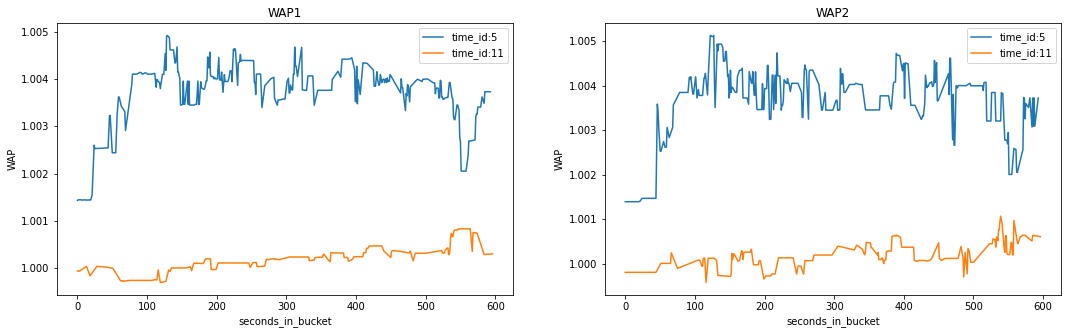

In [6]:
fig,axes = plt.subplots(1,2,figsize=(18,5))
axes[0].plot(book_5['seconds_in_bucket'],book_5['wap1'],label='time_id:5')
axes[0].plot(book_11['seconds_in_bucket'],book_11['wap1'],label='time_id:11')
axes[0].set_xlabel('seconds_in_bucket')
axes[0].set_ylabel('WAP')
axes[0].set_title('WAP1')
axes[0].legend()
axes[1].plot(book_5['seconds_in_bucket'],book_5['wap2'],label='time_id:5')
axes[1].plot(book_11['seconds_in_bucket'],book_11['wap2'],label='time_id:11')
axes[1].set_xlabel('seconds_in_bucket')
axes[1].set_ylabel('WAP')
axes[1].set_title('WAP2')
axes[1].legend()

<font color=red>From **Figure 1**, we can clearly see the correlation between **volatility $\sigma$** and **wap1, wap2**. The transformation of WAP of stocks with low volatility is very gentle</font>

### Figure 2: **log_return1** and **log_return2**

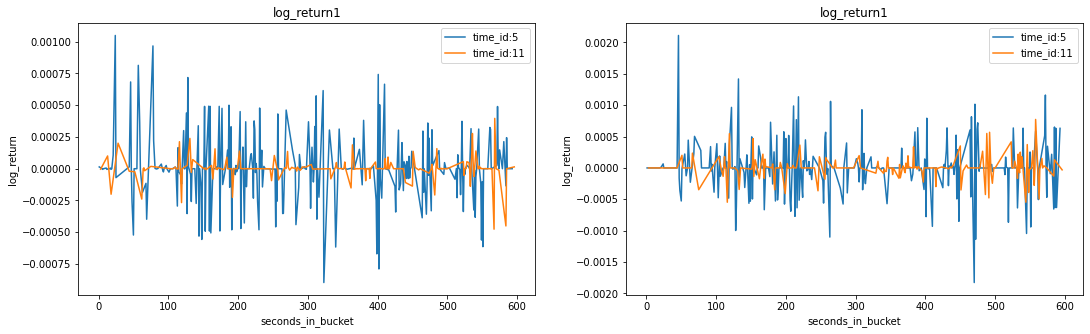

In [7]:
fig,axes = plt.subplots(1,2,figsize=(18,5))
axes[0].plot(book_5['seconds_in_bucket'],book_5['log_return1'],label='time_id:5')
axes[0].plot(book_11['seconds_in_bucket'],book_11['log_return1'],label='time_id:11')
axes[0].set_xlabel('seconds_in_bucket')
axes[0].set_ylabel('log_return')
axes[0].set_title('log_return1')
axes[0].legend()
axes[1].plot(book_5['seconds_in_bucket'],book_5['log_return2'],label='time_id:5')
axes[1].plot(book_11['seconds_in_bucket'],book_11['log_return2'],label='time_id:11')
axes[1].set_xlabel('seconds_in_bucket')
axes[1].set_ylabel('log_return')
axes[1].set_title('log_return1')
axes[1].legend()

<font color=red>From **Figure 2**, we can directly observe the performance of **volatility $\sigma$** in **log_return**. Besides the value of $\sigma$ in the past 10 mins, the statistics of log_return may be helpful</font>

### Figure 3: **wap_balance, price_spread, bid_spread, ask_spread**

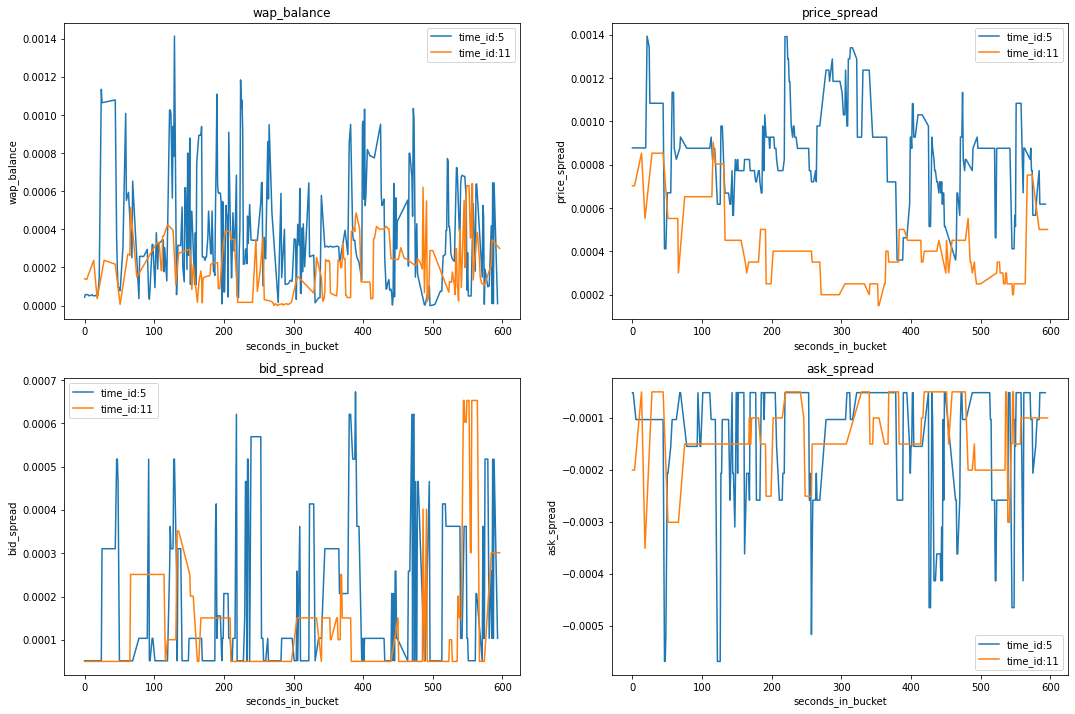

In [8]:
fig,axes = plt.subplots(2,2,figsize=(18,12))
axes = axes.flatten()
feature_dict = ['wap_balance','price_spread','bid_spread','ask_spread']
for i in range(4):
    axes[i].plot(book_5['seconds_in_bucket'],book_5[feature_dict[i]],label='time_id:5')
    axes[i].plot(book_11['seconds_in_bucket'],book_11[feature_dict[i]],label='time_id:11')
    axes[i].set_xlabel('seconds_in_bucket')
    axes[i].set_ylabel(feature_dict[i])
    axes[i].set_title(feature_dict[i])
    axes[i].legend()

<font color=red>From **Figure 3**, we can find little correlation between **volatility $\sigma$** and those four features. They show some trends, but not so strong. We can still add them to the features of the model. It seems that the stock with high **volatility** has high variance, extreme values, high gap in these four features</font>

### Figure 4: **total_volume** and **valume_inbalance**

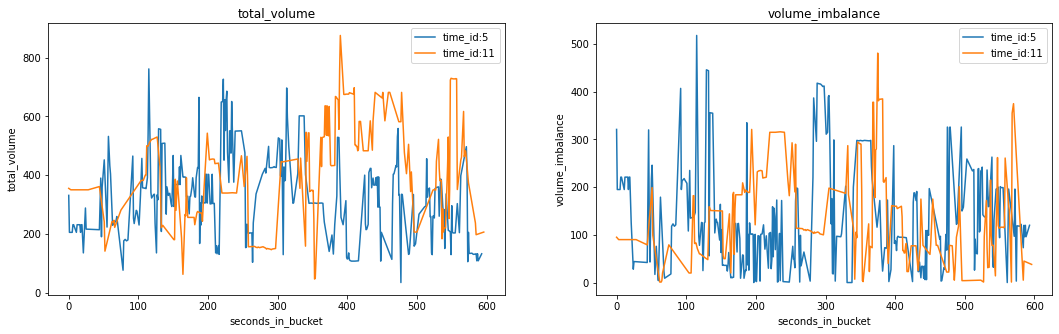

In [9]:
fig,axes = plt.subplots(1,2,figsize=(18,5))
axes[0].plot(book_5['seconds_in_bucket'],book_5['total_volume'],label='time_id:5')
axes[0].plot(book_11['seconds_in_bucket'],book_11['total_volume'],label='time_id:11')
axes[0].set_xlabel('seconds_in_bucket')
axes[0].set_ylabel('total_volume')
axes[0].set_title('total_volume')
axes[0].legend()
axes[1].plot(book_5['seconds_in_bucket'],book_5['volume_imbalance'],label='time_id:5')
axes[1].plot(book_11['seconds_in_bucket'],book_11['volume_imbalance'],label='time_id:11')
axes[1].set_xlabel('seconds_in_bucket')
axes[1].set_ylabel('volume_imbalance')
axes[1].set_title('volume_imbalance')
axes[1].legend()

<font color=red>From **Figure 4**, we hardly see the correlations between **volatility $\sigma$** and **total_volume, volume_imbalance**</font>

In [10]:
stock_id = 0
trade = pd.read_parquet('../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id='+str(stock_id))
trade.head()

time_id  seconds_in_bucket     price  size  order_count
0        5                 21  1.002301   326           12
1        5                 46  1.002778   128            4
2        5                 50  1.002818    55            1
3        5                 57  1.003155   121            5
4        5                 68  1.003646     4            1

In [11]:
trade_sub = trade.groupby(['time_id'])['price'].agg(realized_volatility).to_frame().reset_index()
trade_sub.columns = ['time_id','realized volatility']
trade_sub.head()

time_id  realized volatility
0        5             0.002006
1       11             0.000901
2       16             0.001961
3       31             0.001561
4       62             0.000871

In [12]:
trade['log_return'] = trade.groupby(['time_id'])['price'].apply(log_return)
trade_5 = trade.loc[trade['time_id']==5]
trade_62 = trade.loc[trade['time_id']==62]
trade_5.head()

time_id  seconds_in_bucket     price  size  order_count  log_return
0        5                 21  1.002301   326           12         NaN
1        5                 46  1.002778   128            4    0.000476
2        5                 50  1.002818    55            1    0.000040
3        5                 57  1.003155   121            5    0.000336
4        5                 68  1.003646     4            1    0.000489

### Figure 5: **price, log_return, size, order_count** in **Trade**

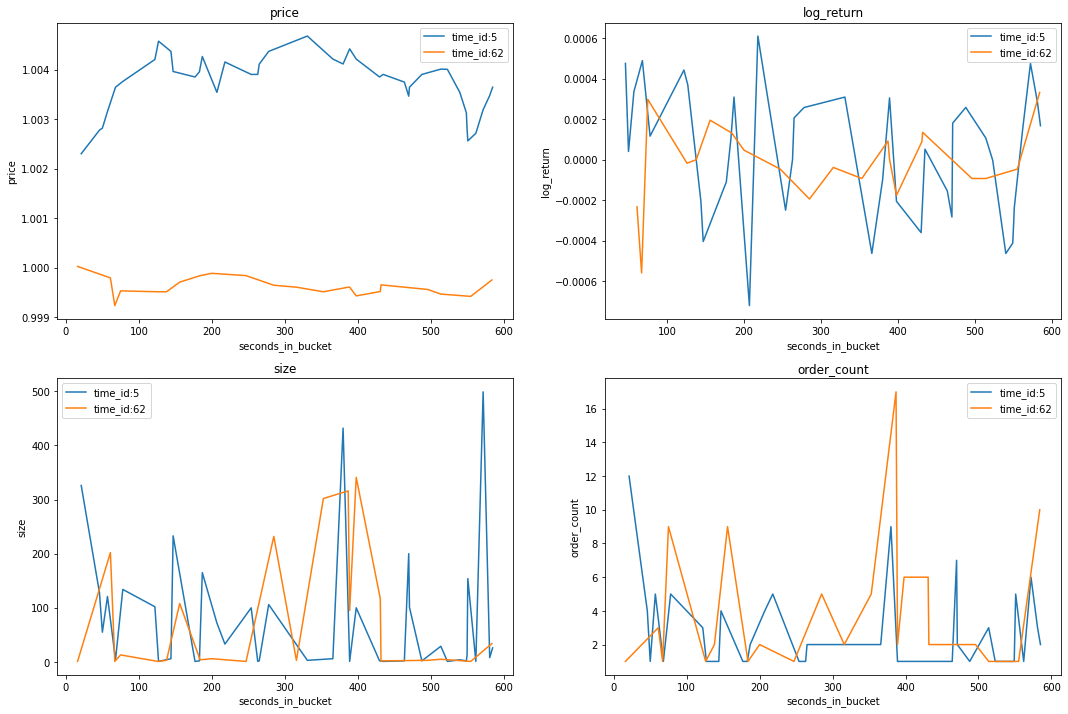

In [13]:
fig,axes = plt.subplots(2,2,figsize=(18,12))
axes = axes.flatten()
feature_dict = ['price','log_return','size','order_count']
for i in range(4):
    axes[i].plot(trade_5['seconds_in_bucket'],trade_5[feature_dict[i]],label='time_id:5')
    axes[i].plot(trade_62['seconds_in_bucket'],trade_62[feature_dict[i]],label='time_id:62')
    axes[i].set_xlabel('seconds_in_bucket')
    axes[i].set_ylabel(feature_dict[i])
    axes[i].set_title(feature_dict[i])
    axes[i].legend()

<font color=red>From **Figure 5**, the difference of **volatility $\sigma$** represented by these characteristics is not obvious. We can still use them to build the model, but there may be more key information hidden in **Trade**</font>

## Capture the features of the trend
We can use a window to select the **information closer to the future**, and obtain the **change trend of features** over time through multiple windows

In [14]:
def get_stats_window(seconds_in_bucket, add_suffix = False):
    df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket]
    # add seconds_in_bucket suffix
    if add_suffix:
        df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
    return df_feature

# Feature Generation & Function Encapsulation

### Accelerate data processing with <font color=red>**numba**</font>

In [15]:
def calculate_wap(df,method):
    if method == 1:
        wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    if method == 2:
        wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def log_return(series):
    return np.log(series).diff()

### Functions used in **numba**

In [16]:
def realized_volatility_numba(values,index=None):
    def log_return_in_realized_volatility(series):
        return np.diff(np.log(series))
    LR = log_return_in_realized_volatility(values)
    return np.sqrt(np.sum(np.square(LR)))

def mean_numba(values,index=None):
    return np.mean(values)

def sum_numba(values,index=None):
    return np.sum(values)

def std_numba(values,index=None):
    return np.std(values)

def min_numba(values,index=None):
    return np.min(values)

def max_numba(values,index=None):
    return np.max(values)

def max_min_numba(values,index=None):
    return np.max(values) - np.min(values)

def count_unique_numba(values,index=None):
    return len(np.unique(values))

## Performance Comparison

### <font color=red>**FeatureEngine** in traditional way</font>

In [17]:
def book_feature(file_path):
    df = pd.read_parquet(file_path)
    df['wap1'] = calculate_wap(df,1)
    df['wap2'] = calculate_wap(df,2)
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    create_feature_dict = {
        'wap1': [np.max, np.min, realized_volatility, np.mean, np.std],
        'wap2': [np.max, np.min, realized_volatility, np.mean, np.std],
        'log_return1': [np.max, np.min, np.mean, np.std],
        'log_return2': [np.max, np.min, np.mean, np.std],
        'wap_balance': [np.max, np.min, np.mean, np.std],
        'price_spread':[np.max, np.min, np.mean, np.std],
        'bid_spread':[np.max, np.min, np.mean, np.std],
        'ask_spread':[np.max, np.min, np.mean, np.std],
        'total_volume':[np.max, np.min, np.mean, np.std],
        'volume_imbalance':[np.max, np.min, np.mean, np.std]
    }
    
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    windows = []
    seconds = [450, 300, 150]
    time_id_list = ['time_id__'+str(second) for second in seconds]
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    for second in seconds:
        windows.append(get_stats_window(seconds_in_bucket = second, add_suffix = True))
    for i,second in enumerate(seconds):
        df_feature = df_feature.merge(windows[i], how = 'left', left_on = 'time_id_', right_on = time_id_list[i])
    df_feature.drop(time_id_list, axis = 1, inplace = True)
    
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

def trade_feature(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby(['time_id'])['price'].apply(log_return)
    create_feature_dict = {
        'price': [np.max, np.min, realized_volatility, np.mean, np.std],
        'log_return': [np.max, np.min, np.mean, np.std],
        'seconds_in_bucket': [count_unique],
        'size': [np.max, np.min, np.mean, np.std],
        'order_count': [np.max, np.min, np.mean, np.std]
    }
    
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    windows = []
    seconds = [450, 300, 150]
    time_id_list = ['time_id__'+str(second) for second in seconds]
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    for second in seconds:
        windows.append(get_stats_window(seconds_in_bucket = second, add_suffix = True))
    for i,second in enumerate(seconds):
        df_feature = df_feature.merge(windows[i], how = 'left', left_on = 'time_id_', right_on = time_id_list[i])
    df_feature.drop(time_id_list, axis = 1, inplace = True)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

### <font color=red>**FeatureEngine** with **numba** engine</font>

In [18]:
def book_feature_numba(file_path):
    df = pd.read_parquet(file_path)
    df['wap1'] = calculate_wap(df,1)
    df['wap2'] = calculate_wap(df,2)
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    df.fillna(0,inplace=True)
    method_dict = {
        'max': max_numba,
        'min': min_numba,
        'mean': mean_numba,
        'std': std_numba
    }
    
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        df_window = df[df['seconds_in_bucket'] >= seconds_in_bucket]
        if add_suffix:
            df_window = df_window.add_suffix('_' + str(seconds_in_bucket))
        return df_window
    
    def get_feature(df_temp,time_id,suffix=None):
        rv_list = ['wap1','wap2']
        statistics_list = ['wap1','wap2','log_return1','log_return2',
                           'wap_balance','price_spread','bid_spread','ask_spread',
                           'total_volume','volume_imbalance']
        if suffix != None:
            rv_list = [x + '_' + str(suffix) for x in rv_list]
            statistics_list = [x + '_' + str(suffix) for x in statistics_list]
        df_feature = df_temp.groupby([time_id])[rv_list].agg(realized_volatility_numba,engine='numba').reset_index()
        df_feature.columns = [col if col == time_id else col + '_rv' for col in df_feature.columns]
        for method in method_dict:
            merge_in = df_temp.groupby([time_id])[statistics_list].agg(method_dict[method],engine='numba').reset_index()
            merge_in.columns = [col if col == time_id else (col + '_'+ method) for col in merge_in.columns]
            df_feature = df_feature.merge(merge_in,how='left',left_on=time_id,right_on=time_id)
        return df_feature
    
    windows = []
    seconds = [450, 300, 150]
    time_id_list = ['time_id_'+ str(second) for second in seconds] 
    df_all = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_all = get_feature(df_all,'time_id')
    for second in seconds:
        windows.append(get_stats_window(seconds_in_bucket = second, add_suffix = True))
    for i,second in enumerate(seconds):
        df_all = df_all.merge(get_feature(windows[i], time_id_list[i], second), 
                              how = 'left', left_on = 'time_id', right_on = time_id_list[i])
    df_all.drop(time_id_list, axis = 1, inplace = True)
    
    stock_id = file_path.split('=')[1]
    df_all['row_id'] = df_all['time_id'].apply(lambda x: f'{stock_id}-{x}')
    df_all.drop(['time_id'], axis = 1, inplace = True)
    return df_all

def trade_feature_numba(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby(['time_id'])['price'].apply(log_return)
    df.fillna(0,inplace=True)
    method_dict = {
        'max': max_numba,
        'min': min_numba,
        'mean': mean_numba,
        'std': std_numba
    }
    
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        df_window = df[df['seconds_in_bucket'] >= seconds_in_bucket]
        if add_suffix:
            df_window = df_window.add_suffix('_' + str(seconds_in_bucket))
        return df_window
    
    def get_feature(df_temp,time_id,suffix=None):
        rv_list = ['price']
        statistics_list = ['price','log_return','size','order_count']
        count_unique_list = ['seconds_in_bucket']
        if suffix != None:
            rv_list = [x + '_' + str(suffix) for x in rv_list]
            statistics_list = [x + '_' + str(suffix) for x in statistics_list]
            count_unique_list = [x + '_' + str(suffix) for x in count_unique_list]
        df_feature = df_temp.groupby([time_id])[rv_list].agg(realized_volatility_numba,engine='numba').reset_index()
        df_feature.columns = [col if col == time_id else col + '_rv' for col in df_feature.columns]
        for method in method_dict:
            merge_in = df_temp.groupby([time_id])[statistics_list].agg(method_dict[method],engine='numba').reset_index()
            merge_in.columns = [col if col == time_id else (col + '_'+ method) for col in merge_in.columns]
            df_feature = df_feature.merge(merge_in,how='left',left_on=time_id,right_on=time_id)
        merge_in = df_temp.groupby([time_id])[count_unique_list].agg(count_unique_numba,engine='numba').reset_index()
        merge_in.columns = [col if col == time_id else (col + '_count_unique') for col in merge_in.columns]
        df_feature = df_feature.merge(merge_in,how='left',left_on=time_id,right_on=time_id)
        return df_feature
    
    windows = []
    seconds = [450, 300, 150]
    time_id_list = ['time_id_'+str(second) for second in seconds] 
    df_all = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_all = get_feature(df_all,'time_id')
    for second in seconds:
        windows.append(get_stats_window(seconds_in_bucket = second, add_suffix = True))
    for i,second in enumerate(seconds):
        df_all = df_all.merge(get_feature(windows[i], time_id_list[i], second), 
                              how = 'left', left_on = 'time_id', right_on = time_id_list[i])
    df_all.drop(time_id_list, axis = 1, inplace = True)
    
    df_all = df_all.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_all['row_id'] = df_all['trade_time_id'].apply(lambda x: f'{stock_id}-{x}')
    df_all.drop(['trade_time_id'], axis = 1, inplace = True)
    return df_all

In [19]:
def FeatureEngineering(list_stock_ids,is_train = True,use_numba=False):
    def for_joblib(stock_id):
        data_dir = '../input/optiver-realized-volatility-prediction/'
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # book
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
        if use_numba:
            df_temp = pd.merge(book_feature_numba(file_path_book), 
                               trade_feature_numba(file_path_trade), how='left', on='row_id')
        else:
            df_temp = pd.merge(book_feature(file_path_book), 
                               trade_feature(file_path_trade), how='left', on='row_id')
        return df_temp
    
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    df = pd.concat(df, ignore_index = True)
    return df

In [20]:
train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_stock_ids = train['stock_id'].unique()

In [21]:
%%time
train_feature = FeatureEngineering(train_stock_ids, is_train = True, use_numba=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 29.7min finished


CPU times: user 11 s, sys: 2.08 s, total: 13.1 s
Wall time: 29min 47s


In [22]:
%%time
train_feature_numba = FeatureEngineering(train_stock_ids, is_train = True, use_numba=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 12.0min finished


CPU times: user 6.37 s, sys: 1.72 s, total: 8.09 s
Wall time: 11min 59s


### <font color=red>From above, we can find **numba** engine can save more than 60% time in the process of feature generation</font>

### Save features for later use

In [23]:
train_feature_numba.to_csv('train_feature.csv',index=False)

In [24]:
print(train_feature_numba.shape)

(428932, 241)


## Handling **stock_id** and **time_id**

### (1) Use **statistics** of **volatility $\sigma$** to represent the feature of **stock_id, time_id**

In [25]:
def statistics_rv_time_stock(df):
    vr_cols = []
    for col in df.columns:
        if 'rv' in col:
            vr_cols.append(col)

    df_stock_id = df.groupby(['stock_id'])[vr_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    df_time_id = df.groupby(['time_id'])[vr_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    df = df.merge(df_stock_id, how = 'left', left_on = 'stock_id', right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = 'time_id', right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df

### (2) Use **Target Encoding(TE)**
We can use the **mean value** of the **target volatility $\sigma$** to represent the feature of **stock_id** (Because the same stock series has strong **autocorrelation**)  

<font color=red>**Be ware:** Since the distribution of test set and training set may be different, we use **TE** with noise</font>

In [26]:
from sklearn.model_selection import KFold
def stock_id_TE(df_train,df_test):
    if 'stock_id' not in df_train.columns:
        df_train['stock_id'] = df_train['row_id'].apply(lambda x:x.split('-')[0])
    if 'stock_id' not in df_test.columns:
        df_test['stock_id'] = df_test['row_id'].apply(lambda x:x.split('-')[0])
    stock_id_target_mean = df_train.groupby('stock_id')['target'].mean()
    df_test['stock_id_target_encoding'] = df_test['stock_id'].map(stock_id_target_mean)
    # TE with noise in training set
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 10, shuffle=True,random_state = 19911109)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()
        tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
    df_train['stock_id_target_enc'] = tmp
    return df_train, df_test

### (3) Use **Embedding Layer**

In [27]:
hidden_units = (32,16)
stock_embedding_size = 16
def Embedding_NN(train,hidden_units,stock_embedding_size,num_shape,cat_shape):
    cat_data = train['stock_id']
    stock_id_input = keras.Input(shape=(1,), name='stock_id')
    num_input = keras.Input(shape=(3,), name='num_data')
    
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                            input_length=1, name='stock_embedding')(stock_id_input)
    stock_flattened = keras.layers.Flatten()(stock_embedded)
    out = keras.layers.Concatenate()([stock_flattened, num_input])
    
    for n_hidden in hidden_units:
        out = keras.layers.Dense(n_hidden, activation='selu')(out)
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    model = keras.Model(
        inputs = [stock_id_input, num_input],
        outputs = out,
    )
    return model

### (4) Use **stock_id, time_id** as **category variables**

In [28]:
def category_stock(df_train,df_test):
    df_train['stock_id'].astype('cat')
    df_test['stock_id'].astype('cat')
    return df_train,df_test

## Feature Scaling

In [29]:
def feature_scale(df_train,df_test,features,method=None):
    for f in features:
        if method == 'min_max':
            minimun = df_train[f].min()
            maximum = df_train[f].max()
            df_train[f] = (df_train[f] - minimum) / (maximum - minimum)
            df_test[f] = (df_test[f] - minimum) / (maximum - minimum)
        if method == 'z_score':
            minimum = df_train[f].min()
            std = df_train[f].std()
            df_train[f] = (df_train[f] - minimum) / std
            df_test[f] = (df_test[f] - minimum) / std
    return df_train, df_test

# Correlation Between Target and Feature

### Use **TE** to handling **stock_id, time_id**

In [30]:
train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
test_stock_ids = test['stock_id'].unique()
test_feature = FeatureEngineering(test_stock_ids, is_train = False, use_numba=True)
train_feature = pd.read_csv('../input/optiver-train-data/train_feature.csv')
train_feature.fillna(method='ffill',inplace=True)
train_feature.fillna(0,inplace=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.3s finished


In [31]:
train_feature['stock_id'] = train_feature['row_id'].apply(lambda x: x.split('-')[0]).astype('int64')
train_feature['time_id'] = train_feature['row_id'].apply(lambda x: x.split('-')[1]).astype('int64')
train_feature = train_feature.merge(train, how='left', on=['stock_id','time_id'])
test_feature = test_feature.merge(test, how='right', on=['row_id'])
test_feature.fillna(method='ffill',inplace=True)
test_feature.fillna(0,inplace=True)
train_feature, test_feature = stock_id_TE(train_feature,test_feature)

### Fetch features' name

In [32]:
features = []
for col in train_feature.columns:
    if col not in ['stock_id','time_id','row_id','target']:
        features.append(col)

### Calculate correlations

In [33]:
corr_matrix = train_feature.corr()
corr_target = corr_matrix['target']
corr_target = corr_target.sort_values(ascending = False)
corr_target = corr_target.to_frame()

In [34]:
corr_target.head(500)

target
target                                    1.000000
wap1_150_rv                               0.881767
wap1_300_rv                               0.878975
wap1_rv                                   0.873777
wap2_150_rv                               0.873081
wap2_300_rv                               0.870091
wap2_rv                                   0.863870
wap1_450_rv                               0.857421
wap2_450_rv                               0.849015
log_return1_150_std                       0.838125
log_return1_300_std                       0.835025
log_return1_std                           0.831320
log_return1_450_std                       0.817500
log_return2_150_std                       0.815018
log_return2_300_std                       0.811134
trade_price_150_rv                        0.807621
log_return2_std                           0.807561
trade_price_rv                            0.804318
trade_price_300_rv                        0.796612
log_return1_300_max                       0.796254
log_return1_150_max                       0.794431
log_return2_450_std                       0.793581
price_spread_300_max                      0.793098
log_return2_300_max                       0.792053
price_spread_450_max                      0.791761
log_return2_150_max                       0.790143
price_spread_150_max                      0.787396
trade_log_return_std                      0.782230
log_return1_450_max                       0.780882
wap_balance_300_max                       0.779243
log_return2_450_max                       0.778609
log_return1_max                           0.775318
trade_log_return_150_std                  0.775316
wap_balance_150_max                       0.775128
wap_balance_450_max                       0.773210
log_return2_max                           0.768676
trade_log_return_300_std                  0.766177
trade_log_return_150_max                  0.762053
price_spread_max                          0.759830
trade_log_return_max                      0.758433
price_spread_150_mean                     0.756579
price_spread_300_mean                     0.754666
price_spread_mean                         0.752852
price_spread_300_std                      0.752820
wap_balance_150_std                       0.752558
wap_balance_300_std                       0.752006
price_spread_150_std                      0.750438
wap_balance_max                           0.747289
price_spread_450_mean                     0.747061
trade_log_return_300_max                  0.745506
trade_price_450_rv                        0.745297
wap_balance_450_std                       0.744330
price_spread_450_std                      0.741844
wap2_450_std                              0.740667
wap_balance_std                           0.739256
wap2_300_std                              0.733459
bid_spread_150_max                        0.733027
wap_balance_150_mean                      0.731205
bid_spread_300_max                        0.730600
wap_balance_mean                          0.730177
trade_log_return_450_std                  0.727695
price_spread_std                          0.725863
wap2_150_std                              0.724486
wap_balance_300_mean                      0.724105
wap2_std                                  0.715154
bid_spread_max                            0.711288
wap1_450_std                              0.709903
wap1_300_std                              0.709406
bid_spread_150_std                        0.705558
ask_spread_150_std                        0.705114
wap1_150_std                              0.705095
bid_spread_450_max                        0.704453
wap_balance_450_mean                      0.703519
ask_spread_std                            0.699255
bid_spread_std                            0.699152
wap1_std                                  0.698574
bid_spread_300_std                        0.697991
ask_spread_300_std                        0.696784
trade_price_std

In [35]:
g1_features = []
for col in train_feature.columns:
    if 'rv' in col:
        g1_features.append(col)
corr_target.loc[g1_features,]

target
wap1_rv             0.873777
wap2_rv             0.863870
wap1_450_rv         0.857421
wap2_450_rv         0.849015
wap1_300_rv         0.878975
wap2_300_rv         0.870091
wap1_150_rv         0.881767
wap2_150_rv         0.873081
trade_price_rv      0.804318
trade_price_450_rv  0.745297
trade_price_300_rv  0.796612
trade_price_150_rv  0.807621

In [36]:
train_feature[g1_features].head(5)

wap1_rv   wap2_rv  wap1_450_rv  wap2_450_rv  wap1_300_rv  wap2_300_rv  \
0  0.004499  0.006999     0.001678     0.004069     0.002930     0.004861   
1  0.001204  0.002476     0.000908     0.001850     0.000980     0.001999   
2  0.002369  0.004801     0.001157     0.002972     0.001295     0.003195   
3  0.002574  0.003637     0.000993     0.001410     0.001776     0.002713   
4  0.001894  0.003257     0.001378     0.000873     0.001519     0.002106   

   wap1_150_rv  wap2_150_rv  trade_price_rv  trade_price_450_rv  \
0     0.003796     0.006086        0.002006            0.001048   
1     0.001058     0.002262        0.000901            0.000498   
2     0.002096     0.004004        0.001961            0.000943   
3     0.002168     0.003273        0.001561            0.000327   
4     0.001591     0.002855        0.000871            0.000348   

   trade_price_300_rv  trade_price_150_rv  
0            0.001271            0.001697  
1            0.000563            0.000810  
2            0.001133            0.001586  
3            0.001050            0.001090  
4            0.000452            0.000515

In [37]:
g2_features = []
for col in train_feature.columns:
    if 'std' in col and 'log_return' in col:
        g2_features.append(col)
corr_target.loc[g2_features,]

target
log_return1_std           0.831320
log_return2_std           0.807561
log_return1_450_std       0.817500
log_return2_450_std       0.793581
log_return1_300_std       0.835025
log_return2_300_std       0.811134
log_return1_150_std       0.838125
log_return2_150_std       0.815018
trade_log_return_std      0.782230
trade_log_return_450_std  0.727695
trade_log_return_300_std  0.766177
trade_log_return_150_std  0.775316

In [38]:
train_feature[g2_features].head(5)

log_return1_std  log_return2_std  log_return1_450_std  log_return2_450_std  \
0         0.000259         0.000403             0.000209             0.000499   
1         0.000085         0.000175             0.000125             0.000256   
2         0.000172         0.000350             0.000171             0.000446   
3         0.000234         0.000332             0.000232             0.000332   
4         0.000143         0.000245             0.000229             0.000161   

   log_return1_300_std  log_return2_300_std  log_return1_150_std  \
0             0.000251             0.000413             0.000249   
1             0.000091             0.000187             0.000080   
2             0.000152             0.000387             0.000195   
3             0.000243             0.000373             0.000243   
4             0.000161             0.000232             0.000138   

   log_return2_150_std  trade_log_return_std  trade_log_return_450_std  \
0             0.000400              0.000315                  0.000283   
1             0.000172              0.000162                  0.000154   
2             0.000368              0.000379                  0.000285   
3             0.000363              0.000374                  0.000285   
4             0.000252              0.000185                  0.000178   

   trade_log_return_300_std  trade_log_return_150_std  
0                  0.000283                  0.000310  
1                  0.000146                  0.000163  
2                  0.000264                  0.000335  
3                  0.000360                  0.000406  
4                  0.000136                  0.000137

In [39]:
g3_features = []
for col in train_feature.columns:
    if 'max' in col and 'log_return' in col:
        g3_features.append(col)
corr_target.loc[g3_features,]

target
log_return1_max           0.775318
log_return2_max           0.768676
log_return1_450_max       0.780882
log_return2_450_max       0.778609
log_return1_300_max       0.796254
log_return2_300_max       0.792053
log_return1_150_max       0.794431
log_return2_150_max       0.790143
trade_log_return_max      0.758433
trade_log_return_450_max  0.671212
trade_log_return_300_max  0.745506
trade_log_return_150_max  0.762053

In [40]:
train_feature[g3_features].head(5)

log_return1_max  log_return2_max  log_return1_450_max  log_return2_450_max  \
0         0.001049         0.002112             0.000490             0.001162   
1         0.000396         0.000773             0.000396             0.000773   
2         0.000799         0.001436             0.000283             0.001436   
3         0.000757         0.000860             0.000294             0.000258   
4         0.000912         0.000914             0.000912             0.000376   

   log_return1_300_max  log_return2_300_max  log_return1_150_max  \
0             0.000742             0.001162             0.000742   
1             0.000396             0.000773             0.000396   
2             0.000283             0.001436             0.000799   
3             0.000633             0.000860             0.000633   
4             0.000912             0.000766             0.000912   

   log_return2_150_max  trade_log_return_max  trade_log_return_450_max  \
0             0.001162              0.000610                  0.000475   
1             0.000773              0.000402                  0.000269   
2             0.001436              0.000862                  0.000288   
3             0.000860              0.000546                 -0.000038   
4             0.000914              0.000332                  0.000332   

   trade_log_return_300_max  trade_log_return_150_max  
0                  0.000475                  0.000610  
1                  0.000269                  0.000402  
2                  0.000288                  0.000862  
3                  0.000546                  0.000546  
4                  0.000332                  0.000332

In [41]:
g4_features = []
for col in train_feature.columns:
    if 'min' in col and 'log_return' in col:
        g4_features.append(col)
corr_target.loc[g4_features,]

target
log_return1_min          -0.773768
log_return2_min          -0.769819
log_return1_450_min      -0.778869
log_return2_450_min      -0.777837
log_return1_300_min      -0.794190
log_return2_300_min      -0.792333
log_return1_150_min      -0.793665
log_return2_150_min      -0.791478
trade_log_return_min     -0.758898
trade_log_return_450_min -0.671639
trade_log_return_300_min -0.747144
trade_log_return_150_min -0.762642

In [42]:
train_feature[g4_features].head(5)

log_return1_min  log_return2_min  log_return1_450_min  log_return2_450_min  \
0        -0.000896        -0.001827            -0.000614            -0.001827   
1        -0.000476        -0.000547            -0.000476            -0.000546   
2        -0.000783        -0.001612            -0.000783            -0.001612   
3        -0.001296        -0.001601            -0.000917            -0.001323   
4        -0.000750        -0.000787            -0.000500            -0.000433   

   log_return1_300_min  log_return2_300_min  log_return1_150_min  \
0            -0.000896            -0.001827            -0.000896   
1            -0.000476            -0.000546            -0.000476   
2            -0.000783            -0.001612            -0.000783   
3            -0.001296            -0.001601            -0.001296   
4            -0.000500            -0.000700            -0.000500   

   log_return2_150_min  trade_log_return_min  trade_log_return_450_min  \
0            -0.001827             -0.000721                 -0.000464   
1            -0.000546             -0.000251                 -0.000204   
2            -0.001612             -0.000642                 -0.000642   
3            -0.001601             -0.000880                 -0.000732   
4            -0.000787             -0.000560                 -0.000093   

   trade_log_return_300_min  trade_log_return_150_min  
0                 -0.000464                 -0.000721  
1                 -0.000204                 -0.000251  
2                 -0.000642                 -0.000642  
3                 -0.000732                 -0.000880  
4                 -0.000176                 -0.000195

In [43]:
g5_features = []
for col in train_feature.columns:
    if 'price_spread' in col and 'min' not in col:
        g5_features.append(col)
corr_target.loc[g5_features,]

target
price_spread_max       0.759830
price_spread_mean      0.752852
price_spread_std       0.725863
price_spread_450_max   0.791761
price_spread_450_mean  0.747061
price_spread_450_std   0.741844
price_spread_300_max   0.793098
price_spread_300_mean  0.754666
price_spread_300_std   0.752820
price_spread_150_max   0.787396
price_spread_150_mean  0.756579
price_spread_150_std   0.750438

In [44]:
train_feature[g5_features].head(5)

price_spread_max  price_spread_mean  price_spread_std  \
0          0.001393           0.000852          0.000211   
1          0.000903           0.000394          0.000157   
2          0.001149           0.000725          0.000163   
3          0.001622           0.000860          0.000279   
4          0.000793           0.000397          0.000130   

   price_spread_450_max  price_spread_450_mean  price_spread_450_std  \
0              0.001134               0.000783              0.000180   
1              0.000753               0.000348              0.000143   
2              0.000815               0.000605              0.000104   
3              0.001159               0.001058              0.000071   
4              0.000793               0.000519              0.000136   

   price_spread_300_max  price_spread_300_mean  price_spread_300_std  \
0              0.001339               0.000822              0.000236   
1              0.000753               0.000353              0.000120   
2              0.000958               0.000689              0.000161   
3              0.001622               0.000833              0.000275   
4              0.000793               0.000425              0.000139   

   price_spread_150_max  price_spread_150_mean  price_spread_150_std  
0              0.001391               0.000858              0.000220  
1              0.000753               0.000353              0.000112  
2              0.001149               0.000679              0.000163  
3              0.001622               0.000920              0.000295  
4              0.000793               0.000395              0.000136

In [45]:
g6_features = []
for col in train_feature.columns:
    if 'wap_balance' in col and 'min' not in col:
        g6_features.append(col)
corr_target.loc[g6_features,]

target
wap_balance_max       0.747289
wap_balance_mean      0.730177
wap_balance_std       0.739256
wap_balance_450_max   0.773210
wap_balance_450_mean  0.703519
wap_balance_450_std   0.744330
wap_balance_300_max   0.779243
wap_balance_300_mean  0.724105
wap_balance_300_std   0.752006
wap_balance_150_max   0.775128
wap_balance_150_mean  0.731205
wap_balance_150_std   0.752558

In [46]:
train_feature[g6_features].head(5)

wap_balance_max  wap_balance_mean  wap_balance_std  wap_balance_450_max  \
0         0.001414          0.000388         0.000295             0.001034   
1         0.000639          0.000212         0.000155             0.000639   
2         0.001135          0.000331         0.000245             0.001135   
3         0.001082          0.000380         0.000246             0.000840   
4         0.000724          0.000254         0.000187             0.000660   

   wap_balance_450_mean  wap_balance_450_std  wap_balance_300_max  \
0              0.000366             0.000275             0.001034   
1              0.000269             0.000173             0.000639   
2              0.000365             0.000279             0.001135   
3              0.000358             0.000246             0.000840   
4              0.000364             0.000200             0.000660   

   wap_balance_300_mean  wap_balance_300_std  wap_balance_150_max  \
0              0.000372             0.000272             0.001184   
1              0.000239             0.000157             0.000639   
2              0.000431             0.000292             0.001135   
3              0.000331             0.000225             0.001082   
4              0.000252             0.000187             0.000724   

   wap_balance_150_mean  wap_balance_150_std  
0              0.000397             0.000280  
1              0.000205             0.000157  
2              0.000373             0.000274  
3              0.000362             0.000246  
4              0.000242             0.000192

In [47]:
g7_features = []
for col in train_feature.columns:
    if 'wap' in col and 'std' in col and 'wap_balance' not in col:
        g7_features.append(col)
corr_target.loc[g7_features,]

target
wap1_std      0.698574
wap2_std      0.715154
wap1_450_std  0.709903
wap2_450_std  0.740667
wap1_300_std  0.709406
wap2_300_std  0.733459
wap1_150_std  0.705095
wap2_150_std  0.724486

In [48]:
train_feature[g7_features].head(5)

wap1_std  wap2_std  wap1_450_std  wap2_450_std  wap1_300_std  wap2_300_std  \
0  0.000692  0.000780      0.000510      0.000635      0.000485      0.000583   
1  0.000261  0.000272      0.000233      0.000284      0.000207      0.000240   
2  0.000862  0.000860      0.000535      0.000757      0.000773      0.000885   
3  0.000754  0.000653      0.000418      0.000529      0.000499      0.000508   
4  0.000257  0.000316      0.000253      0.000209      0.000204      0.000270   

   wap1_150_std  wap2_150_std  
0      0.000444      0.000517  
1      0.000220      0.000265  
2      0.000825      0.000850  
3      0.000430      0.000474  
4      0.000258      0.000292

In [49]:
g8_features = []
for col in train_feature.columns:
    if 'bid_spread' in col and ('max' in col or 'std' in col):
        g8_features.append(col)
corr_target.loc[g8_features,]

target
bid_spread_max      0.711288
bid_spread_std      0.699152
bid_spread_450_max  0.704453
bid_spread_450_std  0.674706
bid_spread_300_max  0.730600
bid_spread_300_std  0.697991
bid_spread_150_max  0.733027
bid_spread_150_std  0.705558

In [50]:
train_feature[g8_features].head(5)

bid_spread_max  bid_spread_std  bid_spread_450_max  bid_spread_450_std  \
0        0.000672        0.000162            0.000620            0.000177   
1        0.000652        0.000148            0.000652            0.000237   
2        0.000670        0.000170            0.000670            0.000215   
3        0.000694        0.000199            0.000185            0.000044   
4        0.000466        0.000083            0.000280            0.000024   

   bid_spread_300_max  bid_spread_300_std  bid_spread_150_max  \
0            0.000672            0.000173            0.000672   
1            0.000652            0.000179            0.000652   
2            0.000670            0.000183            0.000670   
3            0.000648            0.000164            0.000648   
4            0.000466            0.000072            0.000466   

   bid_spread_150_std  
0            0.000165  
1            0.000153  
2            0.000154  
3            0.000190  
4            0.000087

### Function to plot featurn with **stock_id**

In [51]:
from tqdm.auto import tqdm
def plot_feature_with_stock(df,feature):
    fig, ax = plt.subplots(16, 7, figsize=(20, 50))
    ax = ax.flatten()
    for i, stock_id in tqdm(enumerate(df['stock_id'].unique())):
        ax[i].scatter(df.query('stock_id == @stock_id')[feature],
                      df.query('stock_id == @stock_id')['target'],
                      s=3,c='r',alpha=0.3)
        ax[i].set_title("stock_id: " + str(stock_id))
    plt.tight_layout()

#### <font color=red>Group according to different **stock_id** and **correlation coefficient** from high to low</font>  
#### <font color=red>Plot the relationship between **feature** and **target**</font>

wap1_150_rv


0it [00:00, ?it/s]

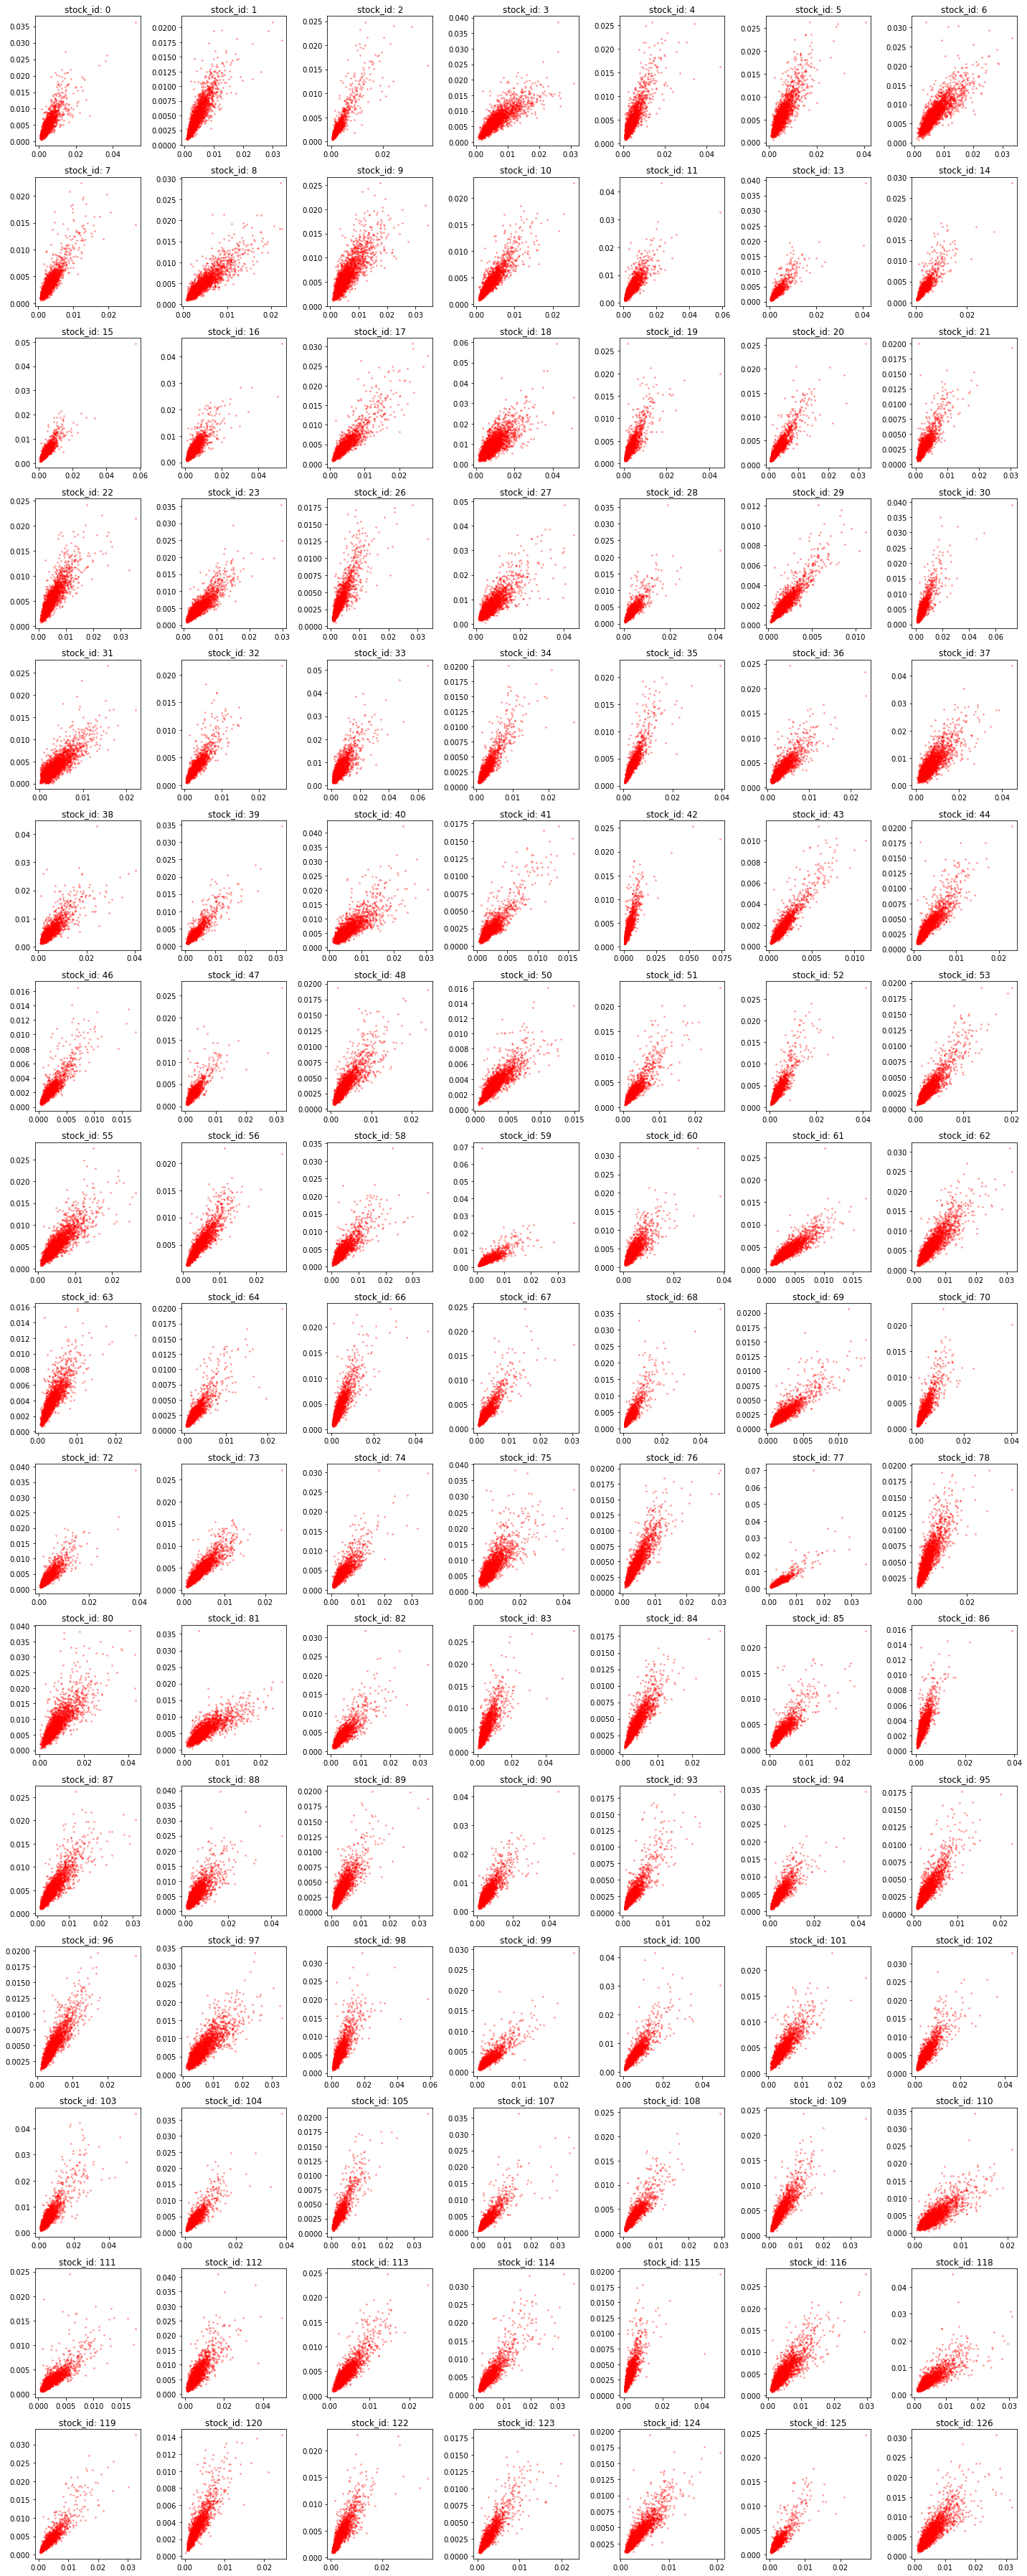

In [52]:
print(corr_target.index[1])
plot_feature_with_stock(train_feature,corr_target.index[1])

wap1_300_rv


0it [00:00, ?it/s]

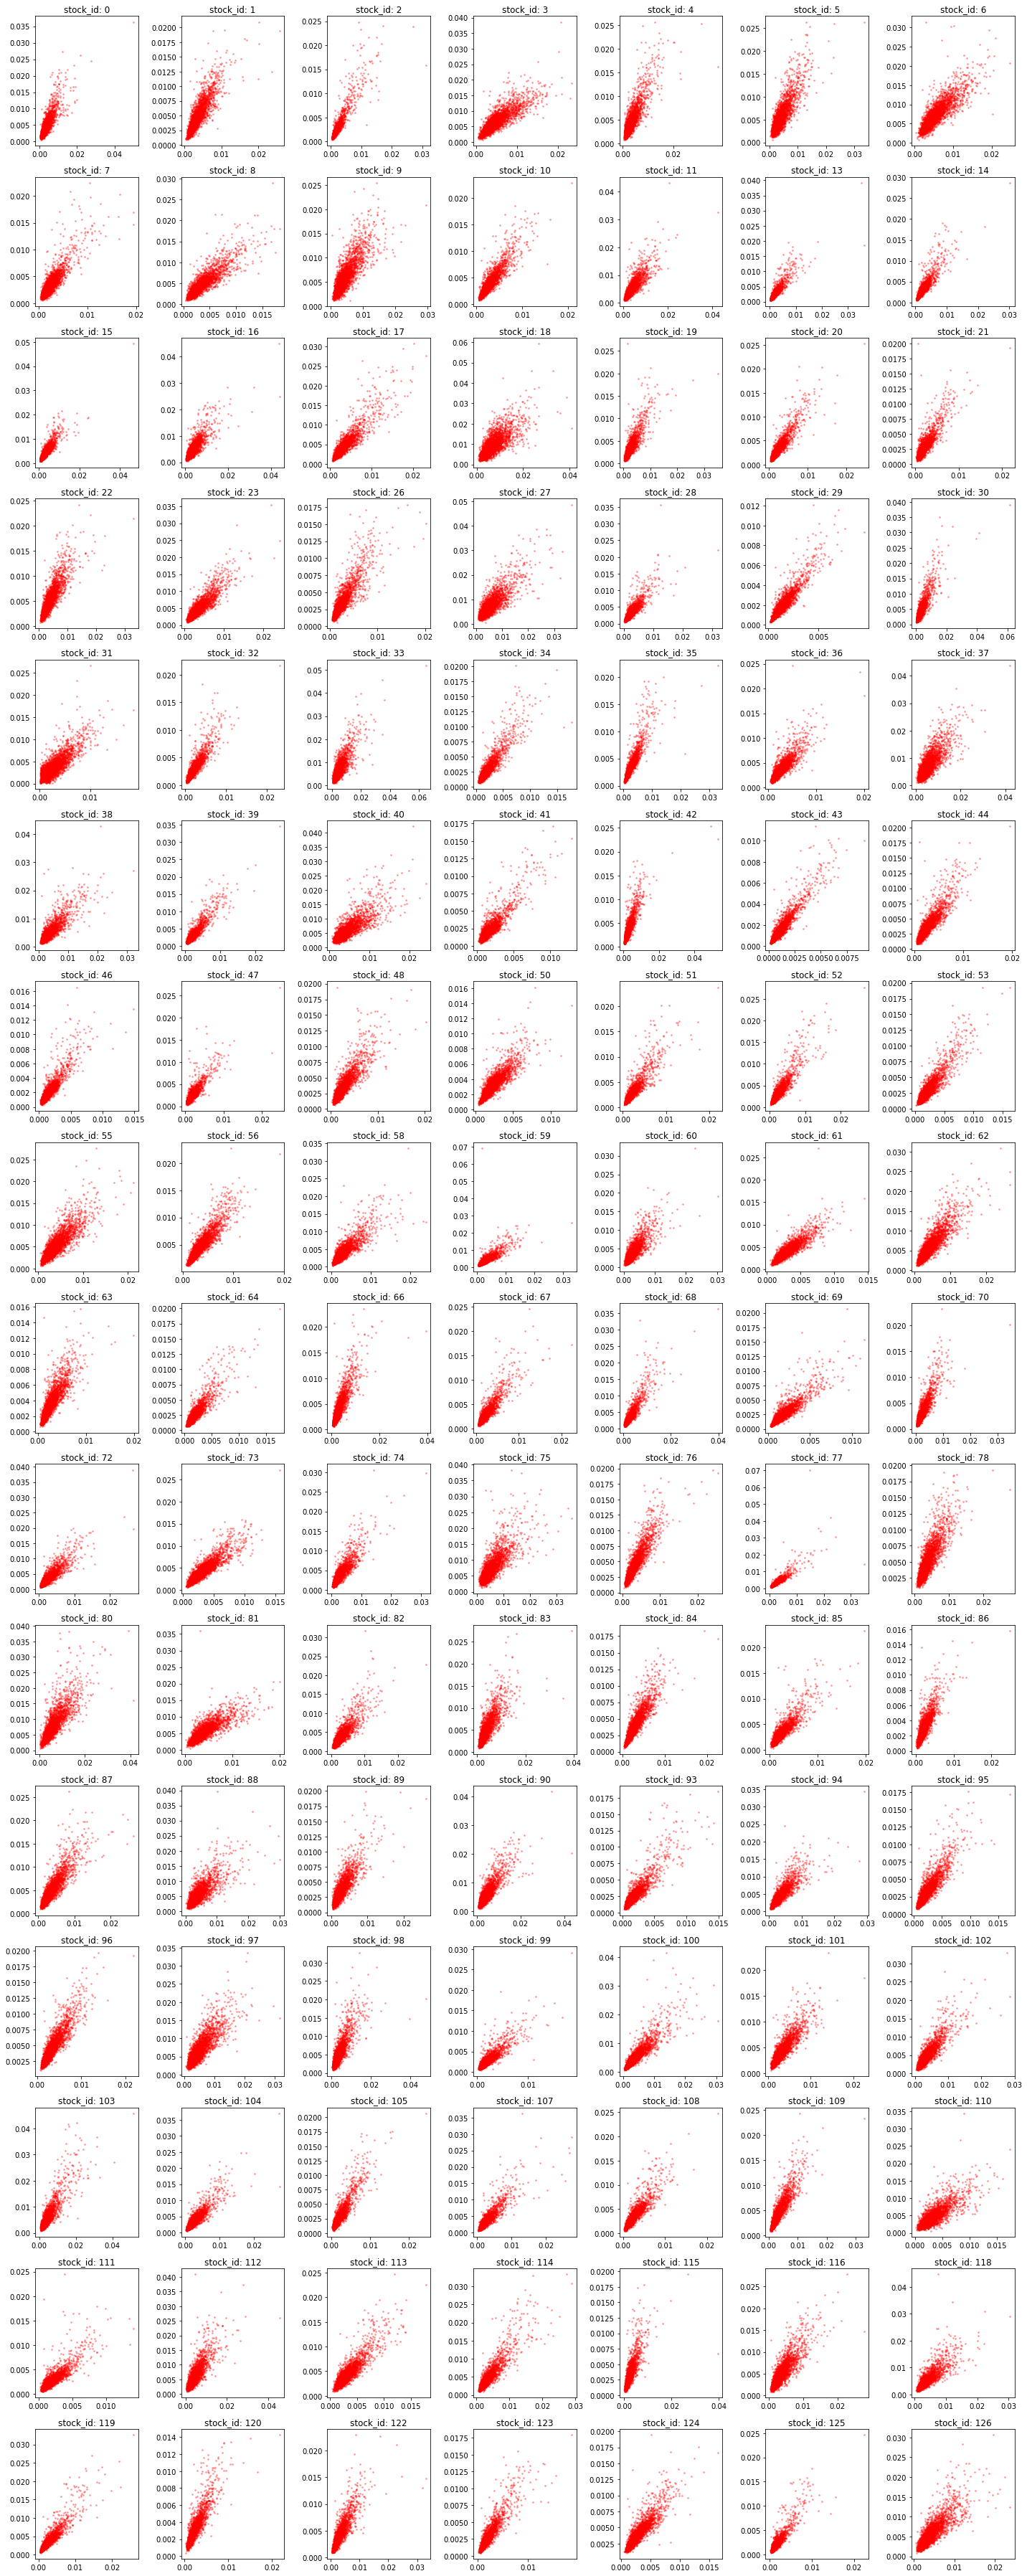

In [53]:
print(corr_target.index[2])
plot_feature_with_stock(train_feature,corr_target.index[2])

log_return2_150_min


0it [00:00, ?it/s]

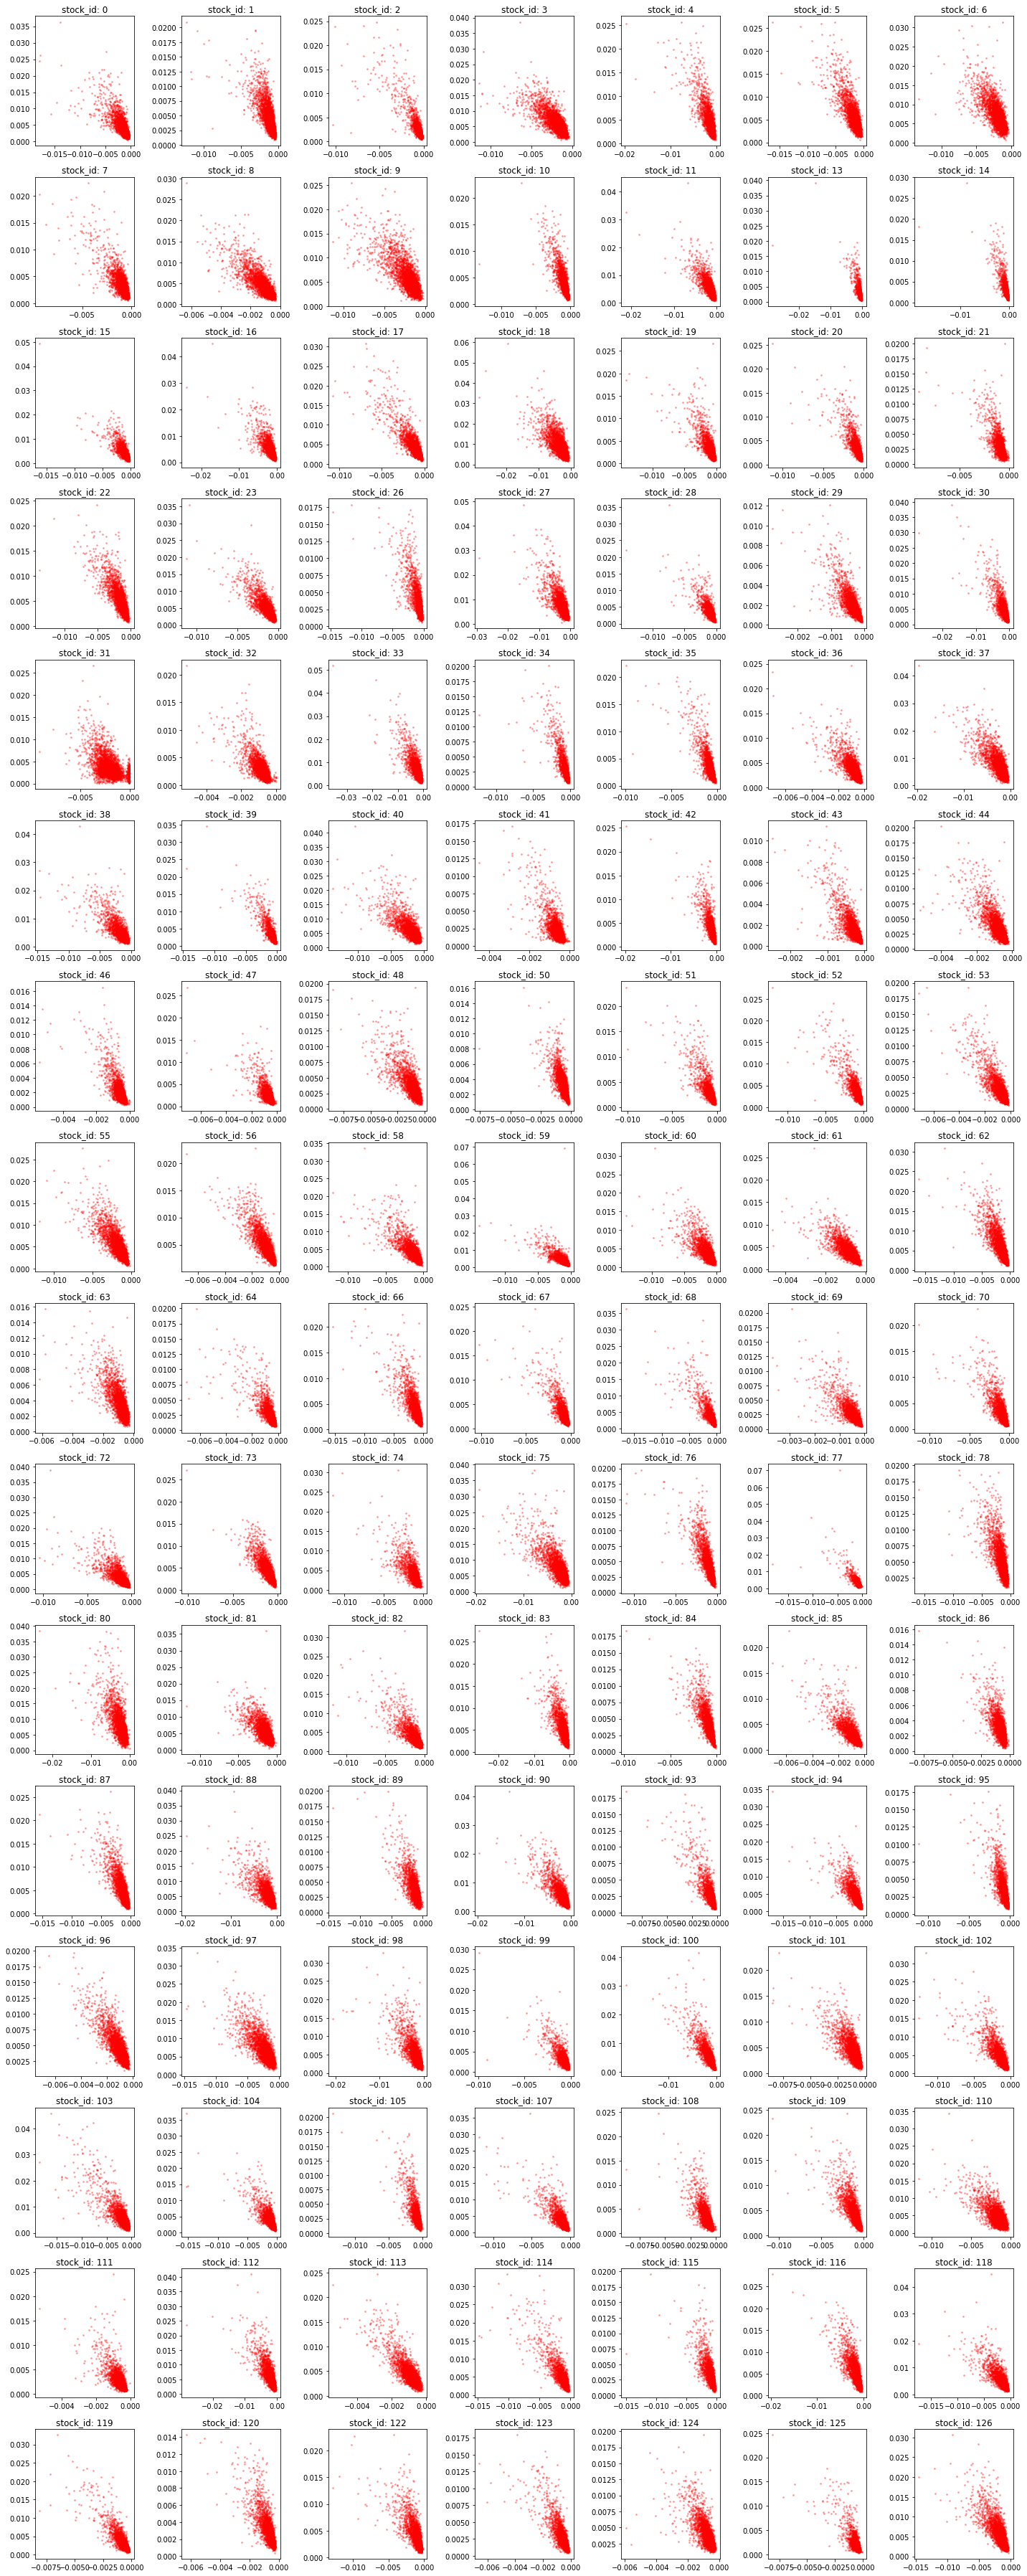

In [54]:
print(corr_target.index[240])
plot_feature_with_stock(train_feature,corr_target.index[240])

### Function to plot **stock** with featurn

In [55]:
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.keys())
def plot_stock_with_feature(df,stock_id):
    fig, ax = plt.subplots(30, 8, figsize=(20, 80))
    ax = ax.flatten()
    for i in range(240):
        ax[i].scatter(df.query('stock_id == @stock_id')[corr_target.index[i+1]],
                      df.query('stock_id == @stock_id')['target'],
                      s=3,c=mcolors.TABLEAU_COLORS[colors[i%10]],alpha=0.3)
        ax[i].set_title(corr_target.index[i+1])
    plt.tight_layout()

stock_id:  0


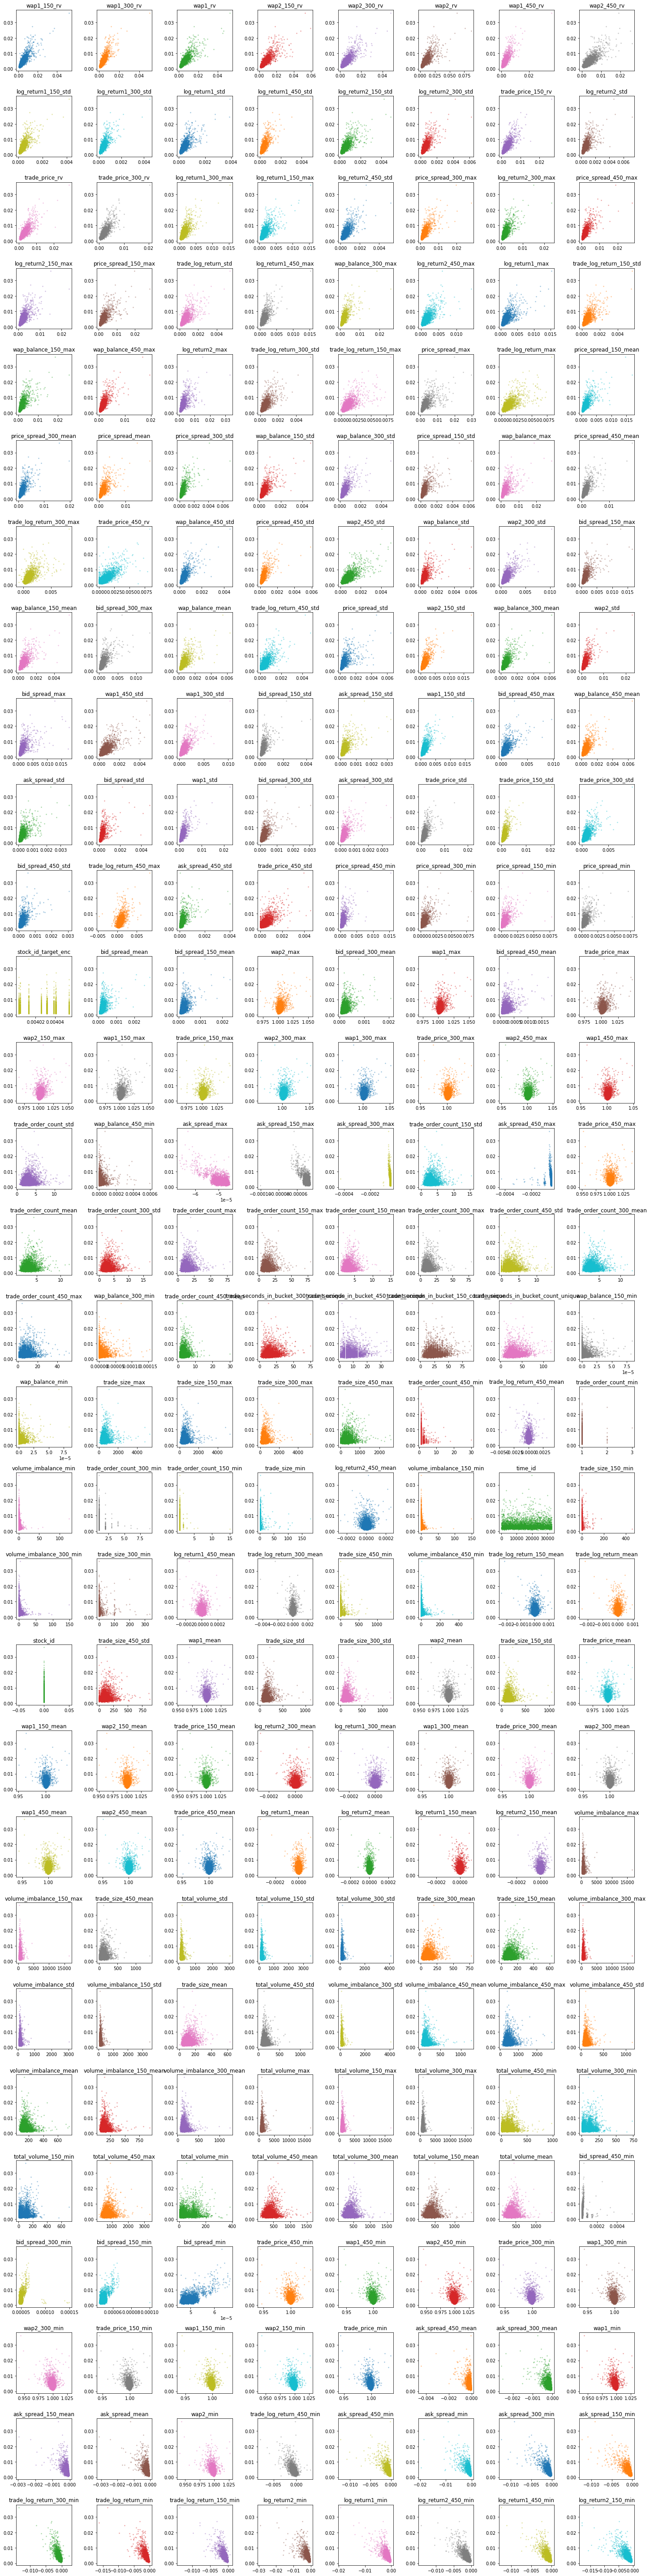

In [56]:
stock_id = 0
print("stock_id: ",stock_id)
plot_stock_with_feature(train_feature,stock_id)

stock_id:  1


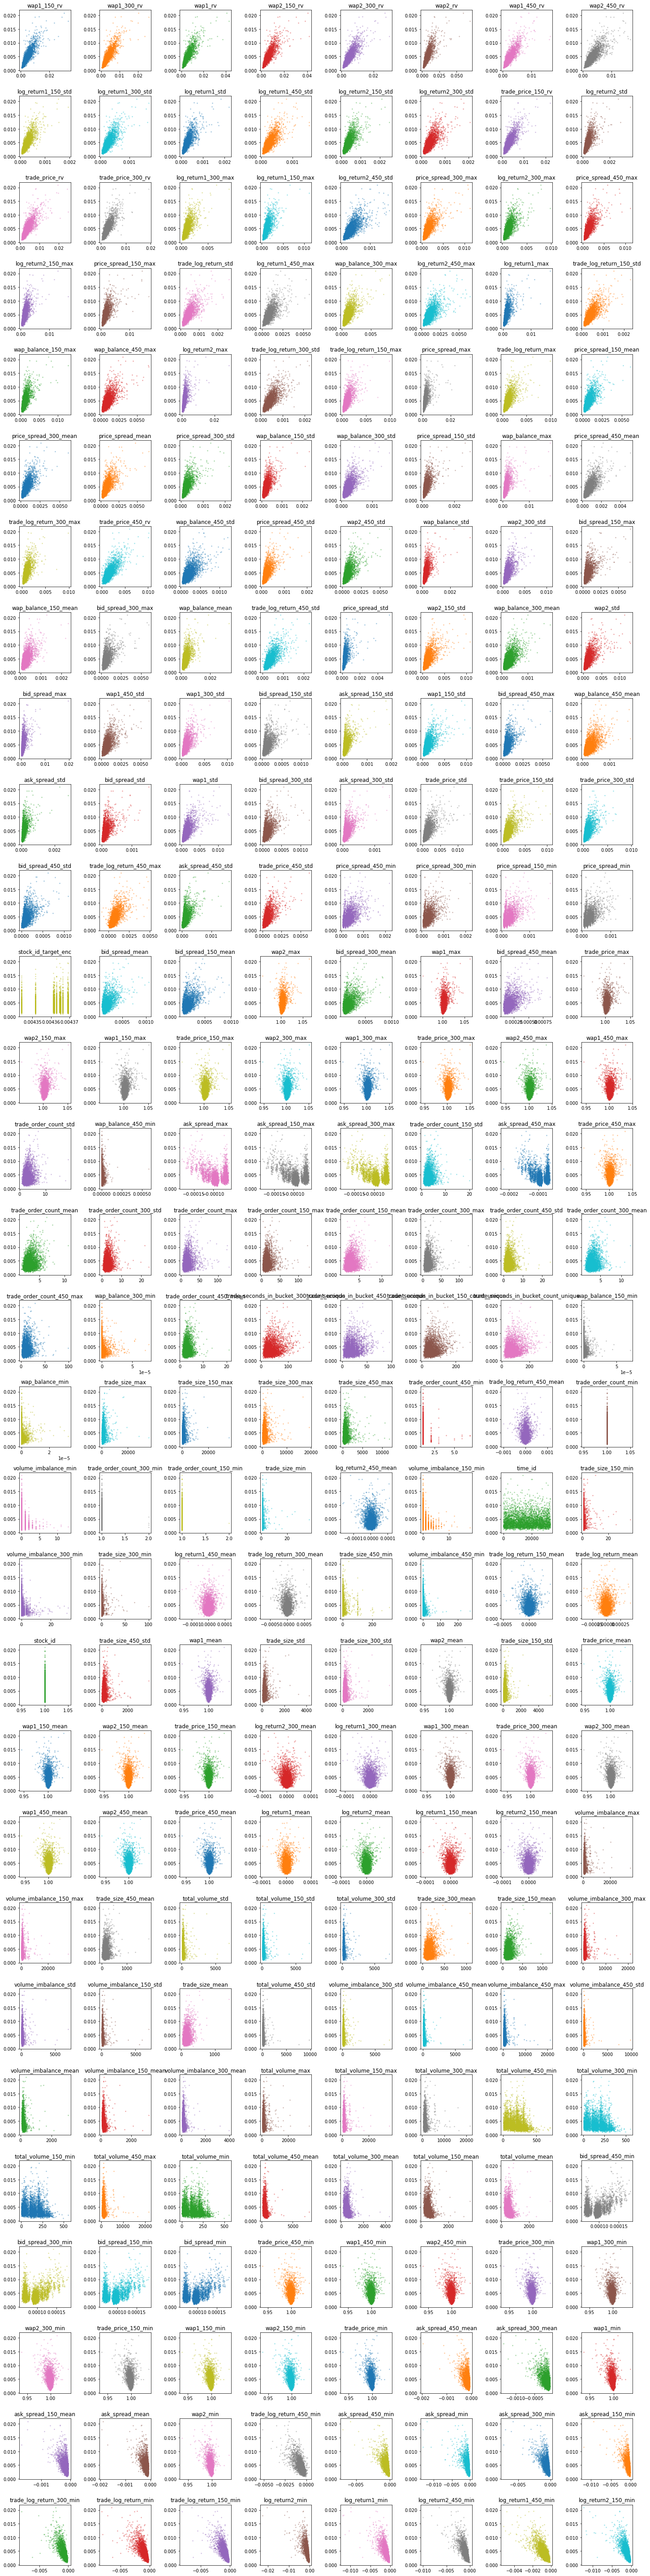

In [57]:
stock_id = 1
print("stock_id: ",stock_id)
plot_stock_with_feature(train_feature,stock_id)

### <font color=red>We can find some useful imformation from above</font>
<font color=red>(1) The **mean value** of variables do not seem to have a linear correlation with the **target** </font>  
<font color=red>(2) The **min value** of variables seem to have a negative linear correlation with the **target** </font>  
<font color=red>(3) The **most important varialbes** might be **realized volatility** in the past and **statistics of log_return**. They all have a strong positive correlation with **target**</font>  
<font color=red>(4) ......</font>

# Mutual Information

# FeatureGen

#### Now, we can package all functions related to feature engineering

In [58]:
def FeatureGen(train_load=False,use_TE=False,use_rv_statistics=False,use_category=False,use_scale=None):
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    train_stock_ids = train['stock_id'].unique()
    test_stock_ids = test['stock_id'].unique()
    # If train_data already saved, we can load it directly to save time in FeatureGen
    if train_load:
        train_feature = pd.read_csv('../input/optiver-train-data/train_feature.csv')
    else:
        train_feature = FeatureEngineering(train_stock_ids, is_train = True, use_numba=True)
    test_feature = FeatureEngineering(test_stock_ids, is_train = False, use_numba=True)
    
    train_feature['stock_id'] = train_feature['row_id'].apply(lambda x: x.split('-')[0]).astype('int64')
    train_feature['time_id'] = train_feature['row_id'].apply(lambda x: x.split('-')[1]).astype('int64')
    train_feature = train_feature.merge(train, how='left', on=['stock_id','time_id'])
    test_feature = test_feature.merge(test, how='right', on=['row_id'])
    test_feature.fillna(method='ffill',inplace=True)
    test_feature.fillna(0,inplace=True)
    # Whether to use Target Encoding
    if use_TE:
        train_feature, test_feature = stock_id_TE(train_feature,test_feature)
    # Whether to use realized volatility statistics
    if use_rv_statistics:
        train_feature = statistics_rv_time_stock(train_feature)
        test_feature = statistics_rv_time_stock(test_feature)
    # Whether to make stock_id be category variable
    if use_category:
        train_feature, test_feature = category_stock(train_feature,test_feature)
    # Whether to use feature scaling
    featurns_scaling = []
    if use_scale != None:
        train_feature, test_feature = feature_scale(train_feature,test_feature,features_scaling,method=use_scale)
    
    return train_feature, test_featurn